In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
len(train_df) + len(test_df)

758

## Data viusalization

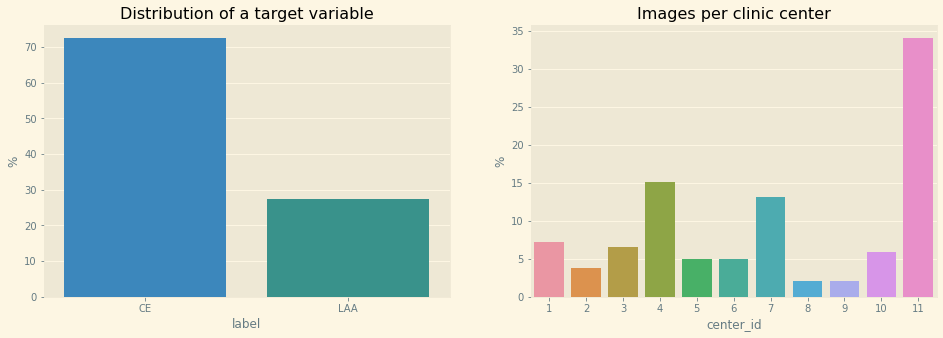

Train Size = 754
Test Size = 4


In [5]:
##### CLASS DISTRIBUTION

plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [6]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [7]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


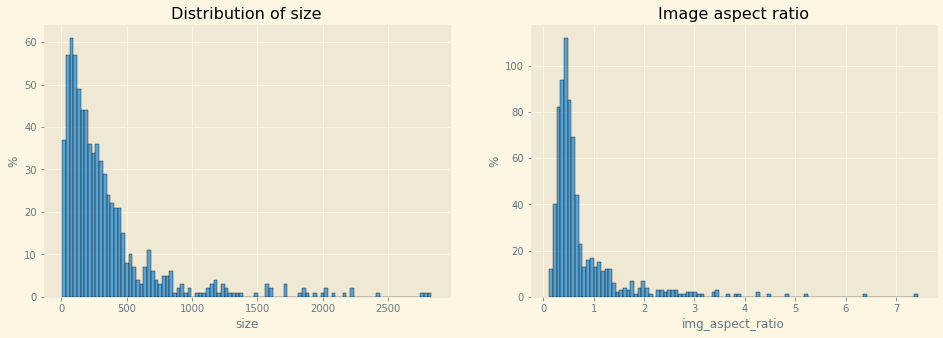

In [8]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

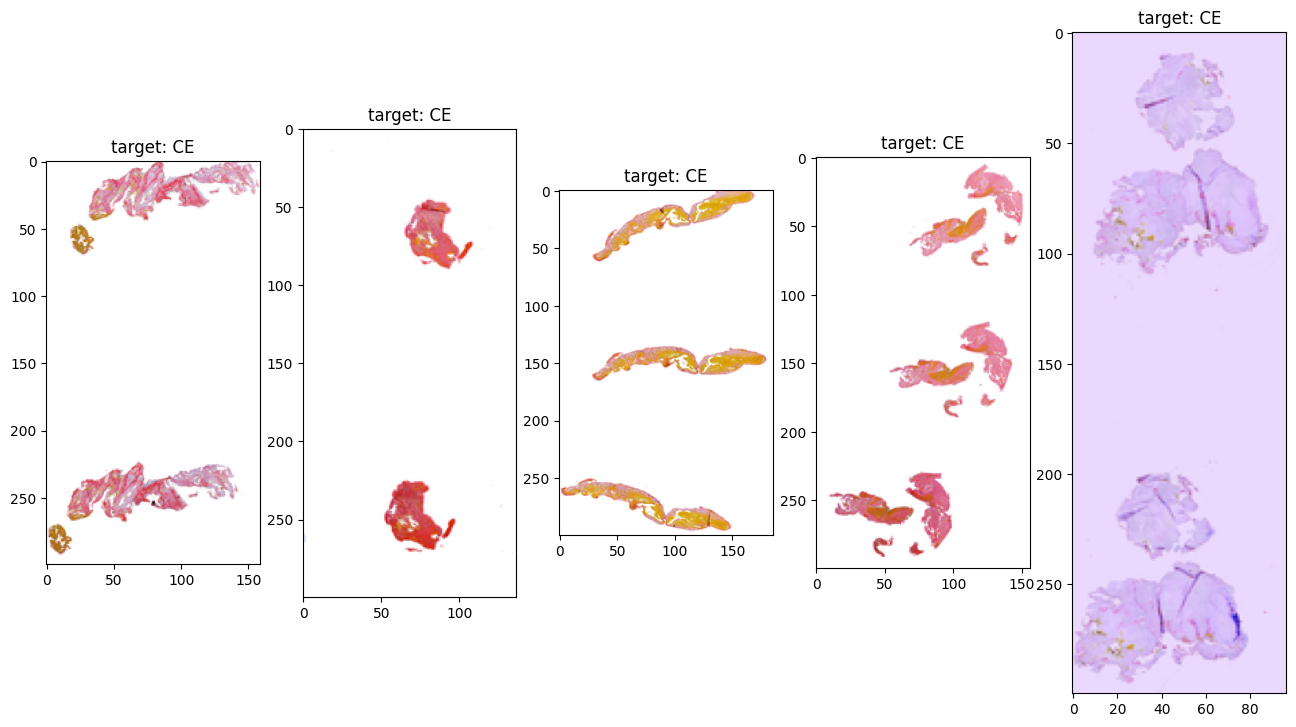

In [9]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

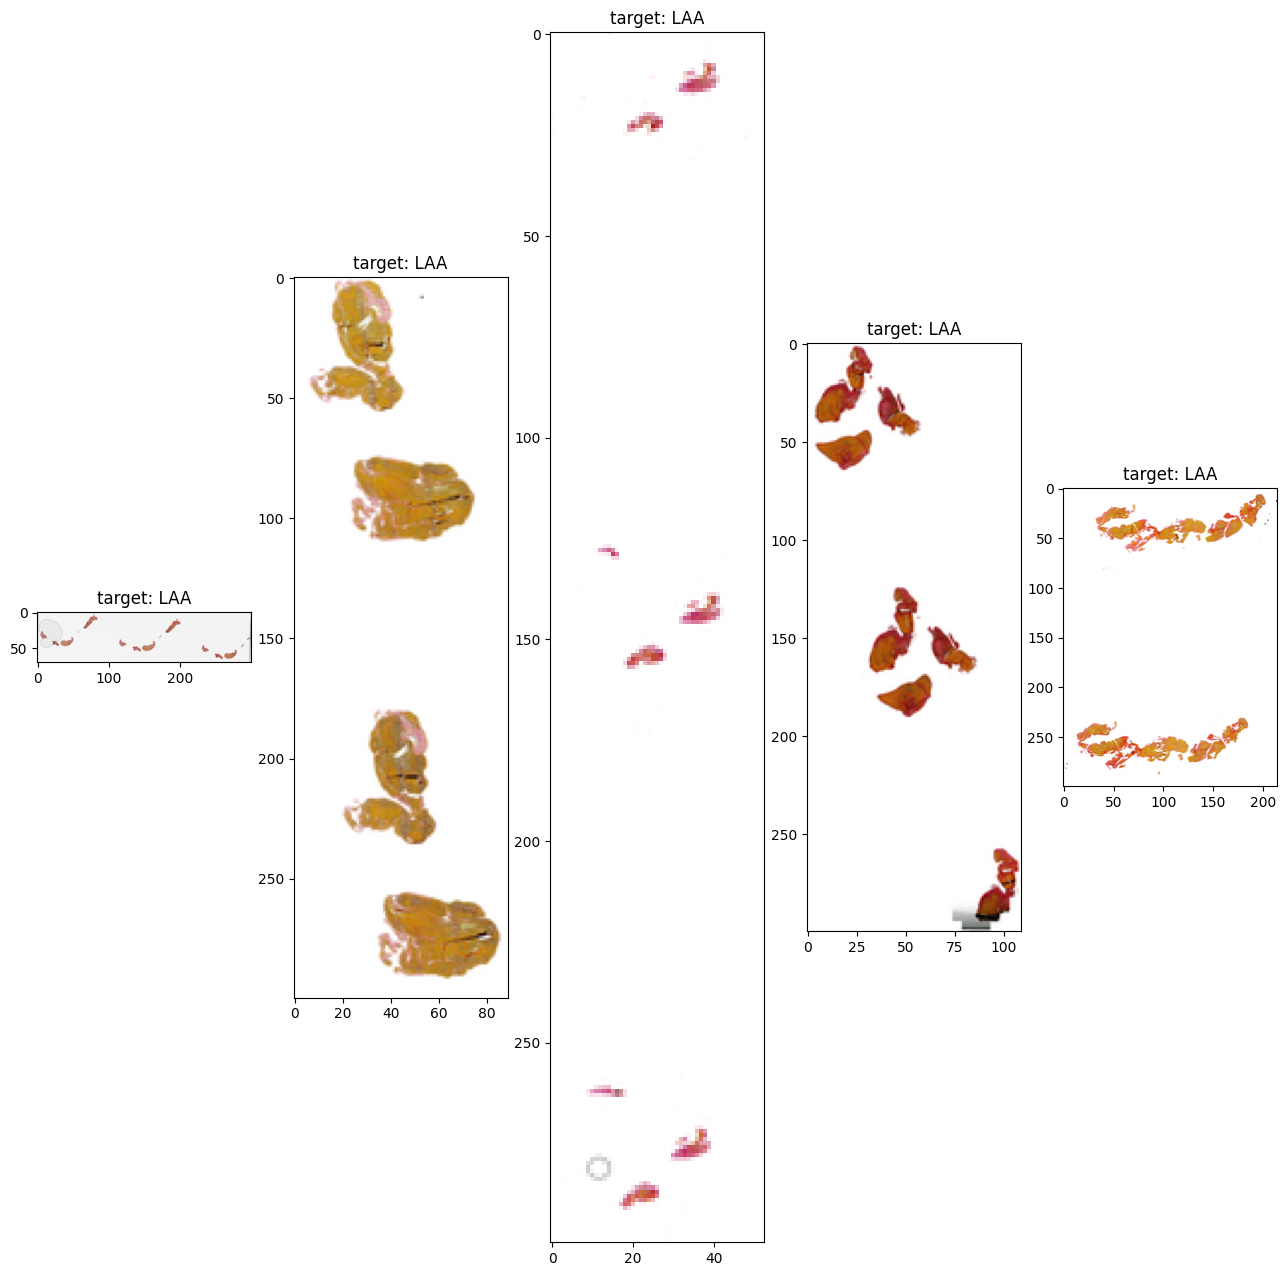

In [10]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

## First impressions:

- Images sizes are from small ones to a high-resolution ones
- Images have different aspect ratios
- Backgrounds have different colours
- Clots are usually in the form of multiple small pieces
- Blood clots have different colours

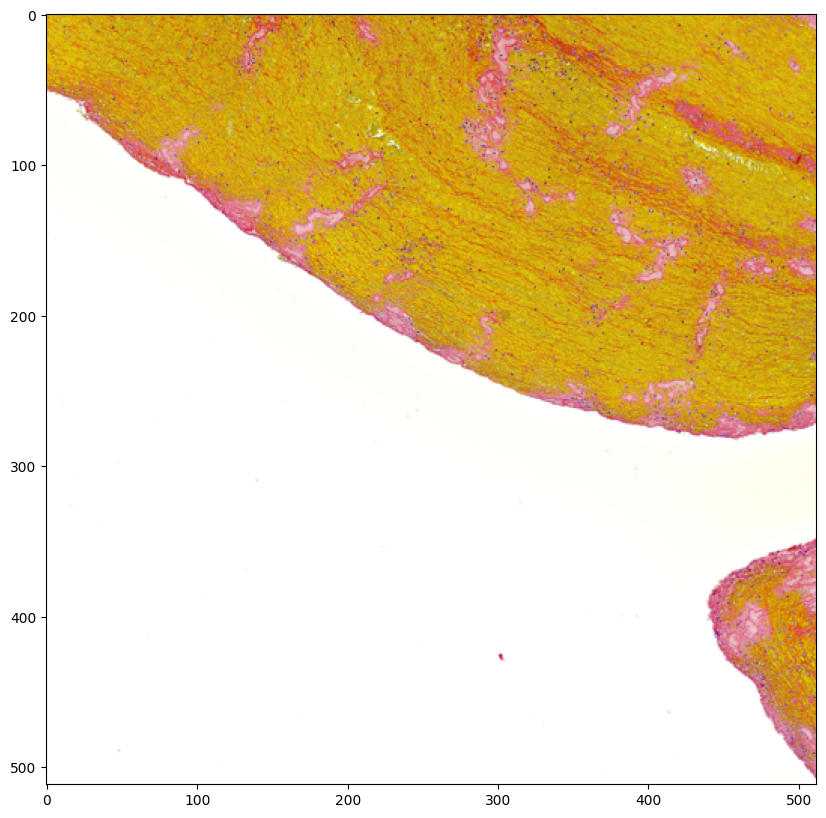

In [11]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


![image](https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg)

## Approach 1

## Loading Data

In [12]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [13]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## Preprocessing

In [14]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 754/754 [48:35<00:00,  3.87s/it] 

CPU times: user 15min 34s, sys: 3min 17s, total: 18min 52s
Wall time: 48min 35s


In [15]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [16]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [17]:
print(x_train.shape)

(603, 128, 128, 4)


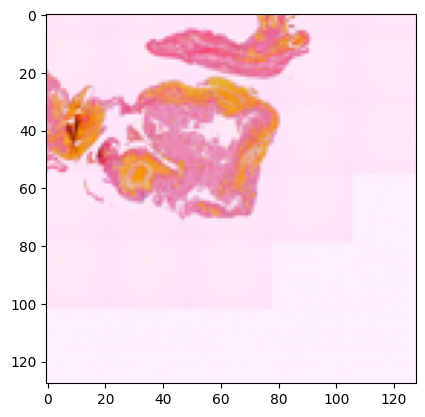

In [18]:
plt.imshow(x_train[0])

## Our CNN approach

In [19]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
from keras import metrics

model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))

model.add(Dropout(0.13))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.13))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1 , activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

In [ ]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## This is where we balance class weights

In [21]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

## Training the model

In [22]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='our_cnn_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [23]:
model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback
)

Epoch 1/10
31/31 [==============================] - 13s 39ms/step - loss: 0.6849 - binary_accuracy: 0.7197 - f1_score: 0.8223 - val_loss: 0.6926 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073

Epoch 00001: val_binary_accuracy improved from -inf to 0.67550, saving model to our_cnn_best.h5
Epoch 2/10
31/31 [==============================] - 0s 16ms/step - loss: 0.6834 - binary_accuracy: 0.4793 - f1_score: 0.4203 - val_loss: 0.6845 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073

Epoch 00002: val_binary_accuracy did not improve from 0.67550
Epoch 3/10
31/31 [==============================] - 0s 15ms/step - loss: 0.6847 - binary_accuracy: 0.7380 - f1_score: 0.8451 - val_loss: 0.6815 - val_binary_accuracy: 0.6755 - val_f1_score: 0.8073

Epoch 00003: val_binary_accuracy did not improve from 0.67550
Epoch 4/10
31/31 [==============================] - 0s 15ms/step - loss: 0.6830 - binary_accuracy: 0.7380 - f1_score: 0.8442 - val_loss: 0.6874 - val_binary_accuracy: 0.6755 - val_f1_sc

In [24]:
best_cnn = load_model('/kaggle/working/our_cnn_best.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

5/5 [==============================] - 1s 36ms/step - loss: 0.6926 - binary_accuracy: 0.6755 - f1_score: 0.8036


[0.6926057934761047, 0.6754966974258423, 0.8035913705825806]

In [31]:
y_test

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [34]:
preds.flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

Text(0.5, 25.722222222222214, 'Actual')

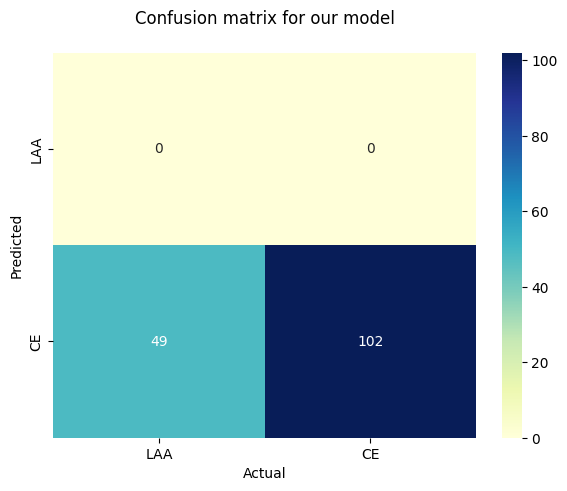

In [36]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix( preds.flatten(), y_test)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## DenseNET

In [37]:
del X_train
del Y_train

In [38]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


In [ ]:
%%time
def preprocess_RGB(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size).convert('RGB')
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    #print(i)
    x1=preprocess_RGB(i)
    X_train.append(x1)
    
Y_train=train_df['target']

 67%|██████▋   | 505/754 [25:41<10:48,  2.60s/it]

In [ ]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [ ]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [ ]:
CE = 0
LAA = 0
for i in y_test:
    if i ==1:
        CE = CE+1
    else:
        LAA = LAA + 1
print(CE)
print(LAA)

In [ ]:
plt.imshow(x_test[0])

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from keras import layers
from keras import metrics

effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(128,128,3)
)

print(len(effnet.layers))
for layer in effnet.layers[0:200]:
    layer.trainable = True
for layer in effnet.layers[201::]:
    layer.trainable = False

Dense_model = Sequential()
Dense_model.add(effnet)
Dense_model.add(layers.GlobalAveragePooling2D())
Dense_model.add(layers.Dropout(0.5))
Dense_model.add(layers.Dense(512,activation='relu'))
Dense_model.add(layers.Dense(64,activation='relu'))
Dense_model.add(layers.Dense(1, activation='sigmoid'))

Dense_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

Dense_model.summary()

In [ ]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(Dense_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='Dense_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [ ]:
Dense_model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback2   
)

In [ ]:
best_Dense = load_model('/kaggle/working/Dense_best.h5', custom_objects={"f1_score": f1_score })
best_Dense.evaluate(x_test,y_test)

In [ ]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_Dense.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")